In [1]:
!pip install qiskit
!pip install qiskit_experiments
!pip install azure-quantum[qiskit]==0.23.201228b1

In [2]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/33e6f75e-0499-425c-8b7d-9f593dde82b6/resourceGroups/AQET/providers/Microsoft.Quantum/Workspaces/CHEM560",
    location = "westus")


from IPython.display import Image
from IPython.core.display import HTML 

import qiskit

from qiskit.quantum_info import DensityMatrix
import qiskit.quantum_info as qi


from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt


In [3]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s2-sim


In [4]:
ionq_simulator_backend = provider.get_backend("ionq.simulator")
ionq_qpu_backend = provider.get_backend("ionq.qpu")
aer_simulator_backend = Aer.get_backend('aer_simulator')

## Alternative installation (if the other installation crashes)

In [5]:
from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate, MSGate
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter, Gate

from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt



In [6]:
provider = IonQProvider("yKJVqlYHrERuzT3N0I255waP7wa8Ui2g")
ionqsim_nat = provider.get_backend("ionq_simulator", gateset="native")
ionq_nat = provider.get_backend("ionq_qpu", gateset="native")

ionqsim_qis = provider.get_backend("ionq_simulator", gateset="native")
ionq_qis = provider.get_backend("ionq_qpu", gateset="native")
qasmbackend = QasmSimulator()

# CHEM 560 Final Project

## Contributors: Ivan Chernyshev, Ben Link, Aodong Liu, Qirui Guo

<div class="alert-info">
Abstract:
    Our goal with the final project is to apply two algorithms in tandem in order to simulate time-dependent Hamiltonians with quantum computation. Previously, we had determined the ground state of minimal hydrogen molecule up to the configuration interaction (Full-CI) picture directly utilizing the unitary coupled-cluster (UCC) ansatz. This, in principle, can also be done by utilizing a different method. Rather than directly computing the coefficients via a VQE algorithm, simulation of quantum dynamics can be performed by explicitly propagating the time-dependent Hamiltonian. In this work, we plan on expressing the ground state Hamiltonian in the first-order Trotterized time-evolution operator, then by performing iterative phase estimation, we can determine the ground state molecular energy of hydrogen. This work is largely inspired by this paper (1), which accumulates the phase from the PEA on an ancilla qubit, which is measured for each shot of the experiment. While the paper explicitly reports the entire potential energy surface along with the dissociation energy, within our time restraint we will focus on characterizing the minimum of the potential energy surface, giving an accurate description of the ground-state hydrogen molecule. Since PEA tends to be less resilient to error than VQE, we plan to do error characterization and correction.
</div>

## Theory and Backgound 

The structure of atoms and molecules is described by quantum mechanics, and quantum computers can simulate them better than traditional computers. Finding solutions to the structure problems traditionally requires high-performance computers with a computational cost that scales exponentially with the size of the system. But the optimization of molecular energies using medium-sized quantum computers has proven efficient for few-electron molecules. In CHEM560, we experimented on the variational quantum eigensolver (VQE) for the hydrogen molecule. In this project, we will demonstrate another algorithm of quantum simulation using Trotterized simulation and the quantum phase estimation algorithm (PEA)<sup>[1]</sup>. 

### Quantum Phase Estimation

PEA is an algorithm to estimate the phase (or eigenvalue) of an eigenvector of a unitary operator. Given a unitary operator $U$, where all the eigenvalues have a norm of 1, the algorithm estimates $U\vert\psi \rangle =e^{2\pi i \theta }|\psi \rangle$. The quantum state $|\psi\rangle$ is an eigenvector and $e^{2\pi i\theta}$ is the corresponding eigenvalue <sup>[6]</sup>. The general PEA curcuit contains some ancilla qubits to represent the state $|\psi\rangle$ and $n$ qubits for the counting register. The intuition of the algorithm is to use phase kickback to write the phase of $U$ to the counting register in the Fourier basis, and then use the inverse QFT to translate it into the computational basis for measurement. 

The qubits are initialized as 

$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$

Then we apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the counting register: 

$ |\psi_1\rangle = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$. 

The unitary operaor $U$ satisfies

$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$

The controlled unitary $CU$ will apply $U$ on the target register only if its corresponding control bit is $|1\rangle$. Applying all the $n$ controlled operations $CU^{2^j}$ with $0\leq j\leq n-1$ and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$ gives us:

$\begin{aligned}
|\psi_{2}\rangle &=\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
&= \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}$

where $k$ is the integer representation of n-bit binary numbers.

To recover the state $\vert2^n\theta\rangle$, we apply an inverse Fourier transform on the register qubit:

$\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle$

Finally, when we make measurement in the computational basis, the above expression will peak near $x = 2^n\theta$ and give the phase in the auxiliary register with high probability:

$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$

and we simply find $\theta=\frac{1}{2^n}$.


The problem with PEA is that it takes $n$ qubits to measure the phase up to n-bit precision. When excuting the algorithm on an actual quantum computer, the multi-qubit gate errors from the $n$ CNOT gates brings impresicion. The error can be avoided by reducing the number of qubits we use, which leads to the Iterative Quantum Phase Estimation (IQPE) Algorithm.

### Iterative Quantum Phase Estimation




### Trotterization

PEA works by preparing an initial state on the main qubit register, y-rotating the ancilla qubit's state into a superposition of |0>'s and |1>'s, applying a time evolution to the main qubit register controlled on the ancilla, reversing the y-rotation, and measuring. One of the most common ways to implement time evolution is through Trotterization.

As we in this class, Chemistry 560, learned when we implemented the Variational Quantum Eigensolver (VQE), it is not always straightforward to express a Hamiltonian directly on a quantum device. One way to remedy this issue is to decompose the Hamiltonian into tensor products of Pauli matrices. For the second-quantized hydrogen molecular Hamiltonian in the Hartree-Fock basis encoded using the Bravyi-Kitaev encoding, this would come in the form<sup>[1]</sup>

$\hat{H} = g_0 {\bf{I}} \otimes {\bf{I}}  + g_1 Z \otimes {\bf{I}} + g_2 {\bf{I}} \otimes Z + g_3 Z \otimes Z + g_4 X \otimes X + g_5 Y \otimes Y $

where the g's are constant coefficients set by the hydrogen bond length.

The time evolution can then be done by doing each of the components in sequence<sup>[1]</sup>:

$e^{-\it{i}\hat{H}t} = e^{-\it{i}g_0 t} e^{-\it{i}g_1 t Z \otimes {\bf{I}}} e^{-\it{i} g_2 t {\bf{I}} \otimes Z} e^{-\it{i} g_3 t Z \otimes Z} e^{-\it{i} g_4 t X \otimes X} e^{-\it{i} g_5 t Y \otimes Y}$ **(1)**

Now, according to the Baker-Campbell-Hausdorff formula, addition of non-commuting exponentials works as follows:

$e^X e^Y = e^{X + Y + \frac{1}{2}[X, Y] + \frac{1}{12}[X,[X,Y]] - \frac{1}{12}[Y,[X,Y]] + ... }$

This is our first source of error. To next-to-leading order in time, the decomposition in Equation 1 in practice equates to<sup>[2]</sup> 

$\Pi_{k=0}^n e^{-\it{i}\hat{H}_k t} = e^{-\it{i} \sum_{k=0}^n \hat{H}_k t - \frac{t^2}{2}\sum_{j=0}^{n-1}\sum_{k=j+1}^n[\hat{H}_j, \hat{H}_k] + O(t^3)}$

This error becomes less pronounced as one shrinks the step-size. Hence, one can compute the time-evolution as a sequence of time-evolutions over smaller time-steps:<sup>[1]</sup>

$e^{-\it{i} \sum_{k=0}^n \hat{H}_k t} \approx (\Pi_{k = 0}^n e^{-\it{i} \hat{H}_k \frac{t}{n}})^n$

and the error in the exponential would be $\propto \frac{t^2}{2 n}\sum_{j=0}^n\sum_{k=j+1}^n[\hat{H}_j, \hat{H}_k] $ <sup>[2]</sup>
    
This is called first-order Trotterization. Second-order Trotterization eliminates $O(t^2)$ error through the following formulation<sup>[3]</sup>: 
    
$e^{-\it{i} \sum_{k=0}^n \hat{H}_k t + O(t^3)} = \Pi_{k = 0}^n e^{-\it{i} \hat{H}_k \frac{t}{2}} \Pi_{k = n}^0 e^{-\it{i} \hat{H}_k \frac{t}{2}} \equiv U_S^2(t)$

Similarly, for 2k-order Trotterization<sup>[3]</sup>,

$  e^{-\it{i} \sum_{k=0}^n \hat{H}_k t + O(t^{(2k+1)})} = (U_S^{2k - 2}(p_k t))^2 U_S^{2k - 2}((1-4p_k)t)(U_S^{2k - 2}(p_k t))^2  \equiv U_S^{2k}(t)$

where $p_k = 1/(4 - 4^{\frac{1}{2k - 1}})$


### Gate errors
The other main source of error in Trotterization comes from the fidelity of the gates themselves, most notably the 2-qubit gates, which have a 97.5% fidelity when implemented on IonQ<sup>[4]</sup>. This is important to talk about, because the most typical methods for reducing the error from the Baker-Campbell-Hausdorff (BCH) formula (doing a higher-order Trotterization and decreasing the time-step size) tends to increase the number of 2-qubit gates, and hence the amount of CNOT error. Figure 1 shows the effects of both the BCH formula and the CNOT error that Martin Savage and Natalie Klco found when attempting to implement Trotterization in 2019:
    
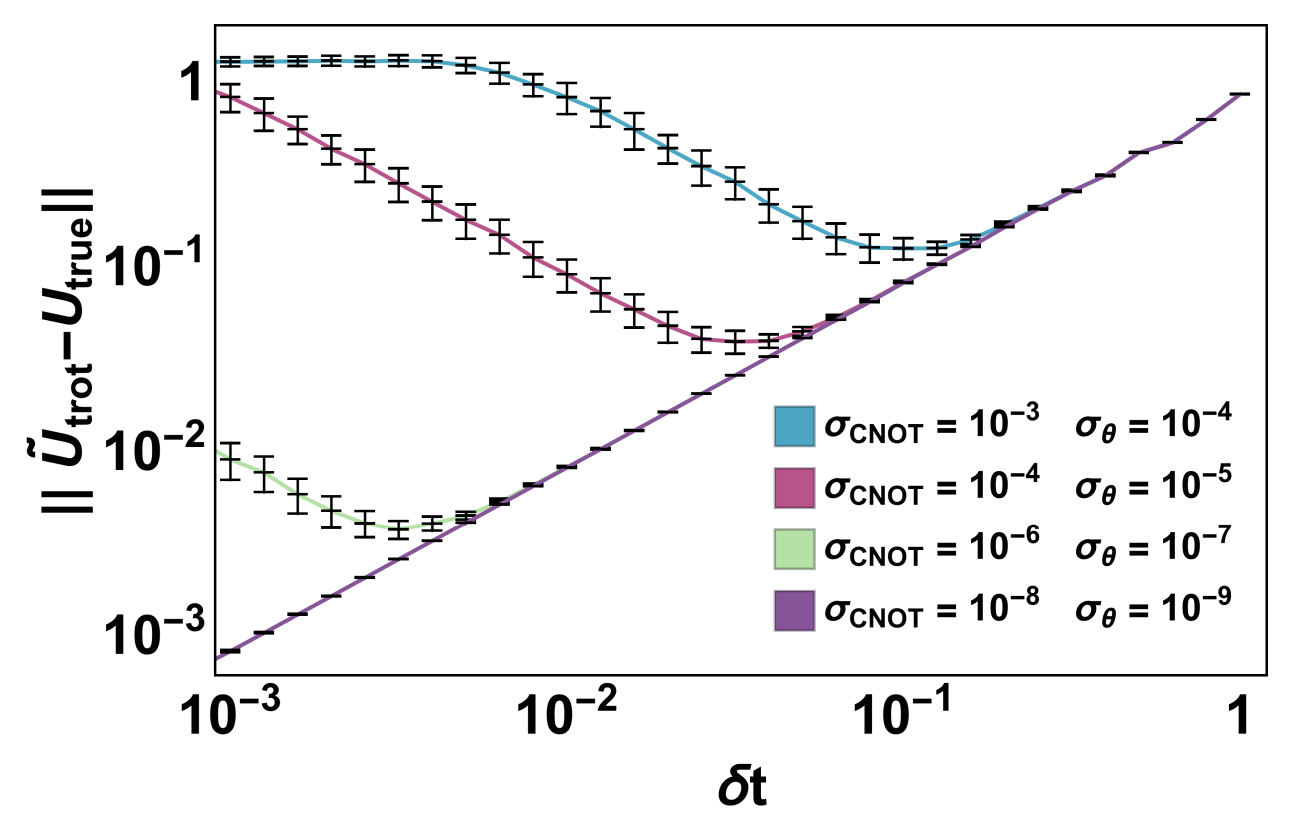

<sup>**Figure 1** Y-axis is the difference between the results of a noisy Trotterization for 1 time-unit and the results of an exact time evolution (again for 1 time-unit), calculated using the Schatten-1 norm. X-axis is the time increment of a Trotterized time evolution. $\sigma_{CNOT}$ is the error rate for a 2-qubit gate and $\sigma_\theta$ is the error-rate for a 1-qubit gate The system is a simple scalar field theory parametrized using the Jordan-Lee-Preskill method. (Borrowed from Savage and Klco 2019)</sup>

    
### Implementation in PEA
PEA features a Trotterization controlled on an ancilla. As such, all single-qubit rotations in the Trotterization will turn into controlled rotations and all 2-qubit rotations will feature the rotating operation being controlled on the ancilla.
As a result, each rotation will require two more CNOT gates than it would without the control on the ancilla. The exception to this is the $g_0$ term, which can be represented as a phase-rotation gate on the ancilla.

## Run using exact time-evolution with linear algebra

### Trotterization

In [7]:

def Hexact(g0,g1,g2,g3,g4,g5):
    return np.array([[g0 + g1 + g2 + g3, 0, 0, g4 - g5], [0, g0 + g1 - g2 - g3, g4 + g5, 0], [0, g4 + g5, g0 - g1 + g2 - g3, 0], [g4 - g5, 0, 0, g0 - g1 - g2 + g3]])


In [8]:
# For the minimal energy, R0 = 0.7
H07 = Hexact(-0.4584,0.3593,-0.4826,0.5818,0.0896,0.0896)

In [9]:
initialstate = np.array([0,0,1,0])
ts07 = [0.01*i for i in range(2000)]

timeev07 = np.array([linalg.expm(-(1j)*t*H07) for t in ts07])

finalstates07 = np.array([np.matmul(u, initialstate) for u in timeev07])

In [10]:
initoverlaps07 = np.array([np.dot(initialstate,fs)*np.conjugate(np.dot(initialstate,fs)) for fs in finalstates07])
energies07 = np.array([np.dot(np.dot(fs,H07),fs) for fs in finalstates07])

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


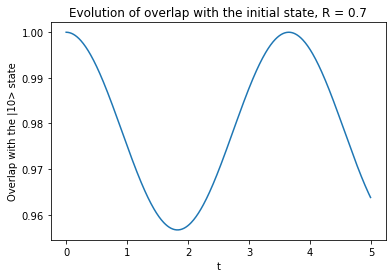

In [11]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.7")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts07[:500], initoverlaps07[:500])
plt.show()

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


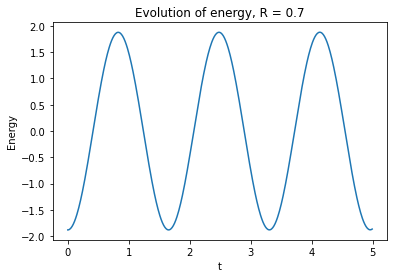

In [12]:
plt.title("Evolution of energy, R = 0.7")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts07[:500], energies07[:500])
plt.show()

In [13]:
# For R0 = 0.65
H065 = Hexact(-0.4323,0.3760,-0.5358,0.5921,0.0883,0.0883)

In [14]:
initialstate = np.array([0,0,1,0])
ts065 = [0.01*i for i in range(2000)]

timeev065 = np.array([linalg.expm(-(1j)*t*H065) for t in ts065])

finalstates065 = np.array([np.matmul(u, initialstate) for u in timeev065])

In [15]:
initoverlaps065 = np.array([np.dot(initialstate,fs)*np.conjugate(np.dot(initialstate,fs)) for fs in finalstates065])
energies065 = np.array([np.dot(np.dot(fs,H065),fs) for fs in finalstates065])

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


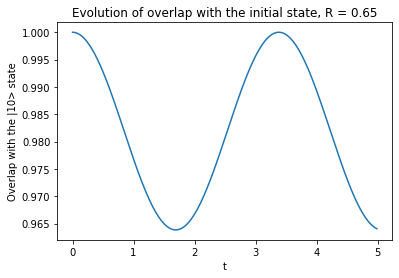

In [16]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.65")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts065[:500], initoverlaps065[:500])
plt.show()

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


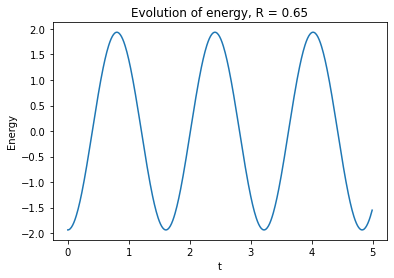

In [17]:
plt.title("Evolution of energy, R = 0.65")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts065[:500], energies065[:500])
plt.show()

In [18]:
# For R0 = 0.75
H075 = Hexact(-0.4804,0.3435,-0.4347,0.5716,0.0910,0.0910)

In [19]:
initialstate = np.array([0,0,1,0])
ts075 = [0.01*i for i in range(2000)]

timeev075 = np.array([linalg.expm(-(1j)*t*H075) for t in ts075])

finalstates075 = np.array([np.matmul(u, initialstate) for u in timeev075])

In [20]:
initoverlaps075 = np.array([np.dot(initialstate,fs)*np.conjugate(np.dot(initialstate,fs)) for fs in finalstates075])
energies075 = np.array([np.dot(np.dot(fs,H075),fs) for fs in finalstates075])

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


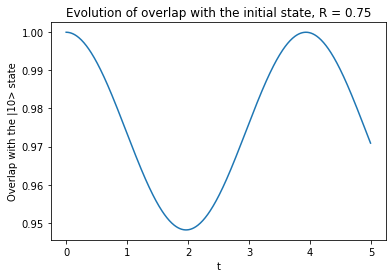

In [21]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.75")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts075[:500], initoverlaps075[:500])
plt.show()

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


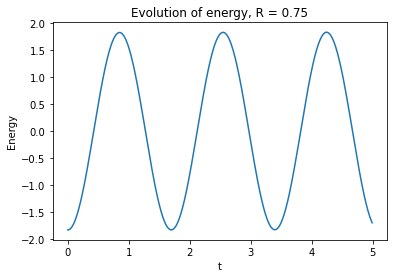

In [22]:
plt.title("Evolution of energy, R = 0.75")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts075[:500], energies075[:500])
plt.show()

## Perfect Qiskit implementation

### Trotterization

In [23]:
# The circuit
def trotterstep(g0,g1,g2,g3,g4,g5,dt, qc):
    #qc.crz(-g1*dt,0,1)
    #qc.crz(-g2*dt,0,2)
    
    #qc.h(1)
    #qc.h(2)
    #qc.cx(1,2)
    #qc.crz(-2*g4*dt,0,2)
    #qc.cx(1,2)
    #qc.h(1)
    #qc.h(2)
    
    qc.rz(2*g1*dt,0)
    qc.rz(2*g2*dt,1)
    
    qc.h(0)
    qc.h(1)
    qc.cx(0,1)
    qc.rz(4*g4*dt,1)
    qc.cx(0,1)
    qc.h(0)
    qc.h(1)
    
    return qc

trotterstep(1,1,1,1,1,1,0.1, QuantumCircuit(2,2)).draw()

┌─────────┐┌───┐                     ┌───┐
q_0: ┤ Rz(0.2) ├┤ H ├──■───────────────■──┤ H ├
     ├─────────┤├───┤┌─┴─┐┌─────────┐┌─┴─┐├───┤
q_1: ┤ Rz(0.2) ├┤ H ├┤ X ├┤ Rz(0.4) ├┤ X ├┤ H ├
     └─────────┘└───┘└───┘└─────────┘└───┘└───┘
c: 2/══════════════════════════════════════════

In [24]:
# trotterstep iterator
def trotterizer_overlap(g0,g1,g2,g3,g4,g5,t, nsteps, bak, shotcount):
    dt = t/nsteps
    
    qc22 = QuantumCircuit(2,2)
    
    qc22.x(0)
    
    for i in range(nsteps):
        trotterstep(g0,g1,g2,g3,g4,g5,dt, qc22)
        
    qc22.x(0)
        
    qc22.measure(0,0)
    qc22.measure(1,1)
    
    job_22 = bak.run(qc22, shots=shotcount)

    result_22 = job_22.result()
    counts_22 = result_22.get_counts(qc22)
    
    if '00' in counts_22.keys():
        return counts_22['00']/shotcount
    
    else:
        return 0
    

In [25]:
# R = 0.7
ts07_qis = [0.01*(i+1) for i in range(2000)]
niters07 = [(i+1) for i in range(2000)]

initialoverlaps07 = np.array([trotterizer_overlap(-0.4584,0.3593,-0.4826,0.5818,0.0896,0.0896, ts07_qis[i], i, qasmbackend, 1000) for i in niters07[:1000]])


/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


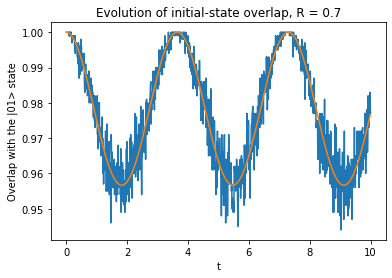

In [26]:
plt.title("Evolution of initial-state overlap, R = 0.7")
plt.ylabel("Overlap with the |01> state")
plt.xlabel("t")
plt.plot(ts07_qis[:1000], initialoverlaps07[:1000])
plt.plot(ts07[:1000], initoverlaps07[:1000])
plt.show()

In [27]:
# R = 0.65
ts65_qis = [0.01*(i+1) for i in range(2000)]
niters65 = [(i+1) for i in range(2000)]

initialoverlaps65 = np.array([trotterizer_overlap(-0.4323,0.3760,-0.5358,0.5921,0.0883,0.0883, ts65_qis[i], i, qasmbackend, 1000) for i in niters65[:1000]])



/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


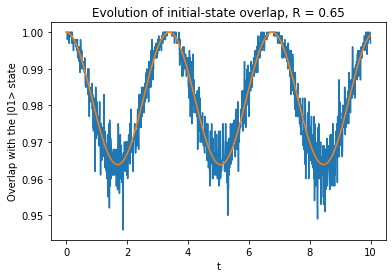

In [28]:
plt.title("Evolution of initial-state overlap, R = 0.65")
plt.ylabel("Overlap with the |01> state")
plt.xlabel("t")
plt.plot(ts65_qis[:1000], initialoverlaps65[:1000])
plt.plot(ts065[:1000], initoverlaps065[:1000])
plt.show()

In [29]:
# R = 0.75
ts75_qis = [0.01*(i+1) for i in range(2000)]
niters75 = [(i+1) for i in range(2000)]

initialoverlaps75 = np.array([trotterizer_overlap(-0.4804,0.3435,-0.4347,0.5716,0.0910,0.0910, ts75_qis[i], i, qasmbackend, 1000) for i in niters75[:1000]])




/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


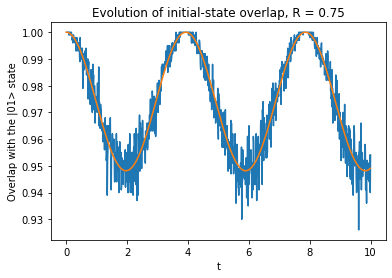

In [30]:
plt.title("Evolution of initial-state overlap, R = 0.75")
plt.ylabel("Overlap with the |01> state")
plt.xlabel("t")
plt.plot(ts75_qis[:1000], initialoverlaps75[:1000])
plt.plot(ts075[:1000], initoverlaps075[:1000])
plt.show()

**1. First, define helper functions**

Starting PEA with Trotterized Hamiltonian.

In [69]:
### Functions to get our circuit, phi, and energy
def construct_circuit(k,prev_result,t0,g_list):
    ### Start by constructing the base circuit. This entails having a set of 
    ### three qubits and measurement of just the last qubit. 
    ### For our purposes, qubit 0 is our ancilla qubit, while qubits
    ### 1 and 2 will hold the state information for our hydrogen molecule

    # Determine phi based on k
    phi = get_phi(prev_result)
    
    
    PEA_Circuit=QuantumCircuit(3,1)
    PEA_Circuit.x(1)
    PEA_Circuit.h(0)
    PEA_Circuit.rz(phi,0)
    PEA_Circuit.barrier()
    ### Now we apply our unitary Trotter, which is a set of applied gates to
    # simulate the Hamiltonian. The four hamiltonians
    # are applied based off Appendix C in the paper:
    # https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007.
    #Z0 rotation
    PEA_Circuit.rz(2**k*t0*g_list[1]/2,0)
    PEA_Circuit.crz(-2**k*t0*g_list[1],0,1)
    PEA_Circuit.barrier()
    
    #Z1 rotation
    PEA_Circuit.rz(2**k*t0*g_list[2]/2,0)
    PEA_Circuit.crz(-2**k*t0*g_list[2],0,2)
    PEA_Circuit.barrier()

    # X0X1
    PEA_Circuit.rz(2**k*t0*g_list[4]/2,0)
    PEA_Circuit.ry(np.pi/2,1)
    PEA_Circuit.ry(np.pi/2,2)
    PEA_Circuit.cx(2,1)
    PEA_Circuit.crz(-2**k*t0*g_list[4],0,1)
    PEA_Circuit.cx(2,1)
    PEA_Circuit.ry(-np.pi/2,1)
    PEA_Circuit.ry(-np.pi/2,2)
    PEA_Circuit.barrier()
    
    # Y0Y1
    PEA_Circuit.rz(2**k*t0*g_list[5]/2,0)
    PEA_Circuit.rx(np.pi/2,1)
    PEA_Circuit.rx(np.pi/2,2)
    PEA_Circuit.cx(2,1)
    PEA_Circuit.crz(-2**k*t0*g_list[5],0,1)
    PEA_Circuit.cx(2,1)
    PEA_Circuit.rx(-np.pi/2,1)
    PEA_Circuit.rx(-np.pi/2,2)
    PEA_Circuit.barrier()
    
    # Final rotation on ancilla
    PEA_Circuit.h(0)
    
    PEA_Circuit.measure(0,0)
    
    return PEA_Circuit

### function to determine phi based on previous measurements
def get_phi(prev_results):
    sum = 0
    k = len(prev_results)
    for l in range(k):
        sum += prev_results[l]/(2**(l-k+1))
    return sum*np.pi


### Function to return the final energy based on all measurements
def get_energy(prev_results,t0,g0,g3):
    b=len(prev_results)
    sum = 0
    for k in range(b):
        sum += prev_results[k]/(2**(k+1))
    return -np.pi*sum/t0+g0+g3

### Function to return the majority rules candidate
def maj_rule(job_result):
    count0 = 0
    count1 = 0
    if ('0' in job_result.get_counts()):
        count0 = job_result.get_counts()['0']
    if ('1' in job_result.get_counts()):
        count1 = job_result.get_counts()['1']
    if (count0 > count1):
        return 0
    elif (count1 > count0):
        return 1
    else:
        return 0

In [70]:
def procedural(t0,g_list,backend,number_cycles,number_shots):
    ### storage values
    prev_res = []
    ### total number of cycles we would like to run
    for i in range(number_cycles):
        qc = construct_circuit(i+1,prev_res,t0,g_list)
        qc_trans = transpile(qc,backend)
        job = backend.run(qc_trans,number_shots)
        ind_result = job.result()
        prev_res.append(maj_rule(ind_result))
    
    ### Once out of loop, can compute energy
    return get_energy(prev_res,t0,g_list[0],g_list[3])

In [83]:
g_values = [-0.4804,0.3288,-0.4347,0.5716,0.0910,0.0910]
Energy = procedural(0.05,g_values,aer_simulator_backend,10,10000)
print(Energy)

TypeError: 'float' object cannot be interpreted as an integer

## References

<sup>[1]</sup> P.J.J. O'Malley, R. Babbush, I.D. Kivlichan, J. Romero, J.R. McClean, R. Barends, J. Kelly, P. Roushan, A. Tranter, N. Ding <em>et al</em>., <em>Scalable Quantum Simulation of Molecular Energies</em>, Phys. Rev. X **6**, 031007 (2016)

<sup>[2]</sup> N. Hatano and M. Suzuki., <em> Finding exponential product formulas of higher orders</em>, 2005, Lecture Notes in Physics, Berlin Springer Verlag, 679, 37 (arXiv:math-ph/0506007) 

<sup>[3]</sup> I. Dhand and B.C. Sanders, <em>Stability of the Suzuki-Trotter decomposition</em>, J. Phys. A **47**, 265206 (2014)

<sup>[4]</sup> K. Wright, K. Beck, S. Debnath, J. Amini, Y. Nam, N. Grzesiak, J.-S. Chen, N. Pisenti, M. Chmielewski, C. Collins, <em>et al</em>., <em>Benchmarking an 11-qubit quantum computer</em>, Nat. Commun. **10** (1), 1 (2019)

<sup>[5]</sup> N. Klco and M. J. Savage, <em>Digitization of Scalar Fields for Quantum Computing</em>, Phys. Rev. A 99, 052335 (2019)

<sup>[6]</sup> A.Yu.Kitaev, <em>Quantum measurements and the Abelian Stabilizer Problem</em> (arXiv:quant-ph/9511026)

In [68]:
# In reserve:

# N. Klco and M. J. Savage, Phys. Rev. A 99, 052335 (2019)


NameError: name 'qc' is not defined

NameError: name 'qc' is not defined